# HW04 L-M Algorithm

## Goal
Implement the Levenberg-Marquardt algorithm  

* Design your own test functions, two variable functions are highly recommended.
* Plot the iteration steps  

## Environment
* Python 3.9
* Jupyter Notebook
* numpy, matplotlib
* pytorch 1.12+

In [1]:
import torch 
from typing import Union, Callable, List, Tuple

def jacobian_approx(p, f):

    try:
        J = torch.autograd.functional.jacobian(f, p, vectorize=True) # create_graph=True
    except RuntimeError:
        J = torch.autograd.functional.jacobian(f, p, strict=True, vectorize=False)

    return J

def LM( p: torch.Tensor,
        function: Callable, 
        data: Union[Tuple, List] = (), 
        ftol: float = 1e-8,
        ptol: float = 1e-8,
        gtol: float = 1e-8,
        tau: float = 1e-3,
        rho1: float = 0.25, 
        rho2: float = 0.75, 
        bet: float = 2,
        gam: float = 3,
        max_iter: int = 50,
    ) -> List[torch.Tensor]:
    """
    Levenberg-Marquardt implementation for least-squares fitting of non-linear functions
    
    :param p: initial value(s)
    :param function: user-provided function which takes p (and additional arguments) as input
    :param data: optional arguments passed to function
    :param ftol: relative change in cost function as stop condition
    :param ptol: relative change in independant variables as stop condition
    :param gtol: maximum gradient tolerance as stop condition
    :param tau: factor to initialize damping parameter
    :param rho1: first gain factor threshold for damping parameter adjustment for Marquardt
    :param rho2: second gain factor threshold for damping parameter adjustment for Marquardt
    :param bet: multiplier for damping parameter adjustment for Marquardt
    :param gam: divisor for damping parameter adjustment for Marquardt
    :param max_iter: maximum number of iterations
    :return: list of results
    """


    fun = lambda p: function(p, *data)

    # use numerical Jacobian if analytical is not provided
    jac_fun = lambda p: jacobian_approx(p, f=fun)

    f = fun(p)
    J = jac_fun(p)
    g = torch.matmul(J.T, f)
    H = torch.matmul(J.T, J)
    mu = tau * torch.max(torch.diag(H))
    v = 2

    p_list = [p]
    cnt = 0
    while cnt < max_iter:
        I = torch.eye(J.shape[1], device=J.device)
        I *= torch.max(torch.maximum(H.diagonal(), I.diagonal()))
        h = -torch.linalg.lstsq(H + mu * I, g, rcond=None, driver=None)[0]   # least square
        f_h = fun(p + h)
        rho_denom = torch.matmul(h, mu * h - g)
        rho_nom = torch.matmul(f, f) - torch.matmul(f_h, f_h)

        if rho_denom > 0:
            rho = rho_nom / rho_denom  
        elif rho_nom > 0:
            rho = torch.inf
        else:
            rho = -torch.inf

        if rho > 0:
            p = p + h
            J = jac_fun(p)
            g = torch.matmul(J.T, fun(p))
            H = torch.matmul(J.T, J)
        p_list.append(p.clone())
        f_prev = f.clone()
        f = fun(p)

        if rho < rho1:
            mu *= bet 
        elif rho > rho2: 
            mu /= gam 

        # stop iteration
        gcon = max(abs(g)) < gtol
        pcon = (h**2).sum()**0.5 < ptol*(ptol + (p**2).sum()**0.5)
        fcon = ((f_prev-f)**2).sum() < ((ftol*f)**2).sum() if rho > 0 else False
        if gcon or pcon or fcon:
            break
        cnt += 1

    return p_list


In [2]:
def emg_model(p, t: torch.Tensor = None):

    alpha, mu, sigma, eta = p

    gauss_term = lambda t, mu, sigma: torch.exp(-0.5 * (t-mu)**2 / sigma**2)
    asymm_term = lambda t, mu, sigma, eta: 1 + torch.erf(eta * (t-mu) / (sigma * 2**0.5))

    alpha = 1 if alpha is None else alpha
    gauss = gauss_term(t, mu, sigma)
    asymm = asymm_term(t, mu, sigma, eta)

    return alpha * gauss * asymm

torch.seed()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

norm, mean, sigm, skew = 8, -1, 60, 7.5

gt_params = torch.tensor([norm, mean, sigm, skew], dtype=torch.float64, device=device)
init_params = torch.tensor([5.5, -0.75, 10, 3], dtype=torch.float64, device=device, requires_grad=True)
cost_fun = lambda p, t, y: (y - emg_model(p, t))**2

print('gt params: ', gt_params.detach().cpu())

t = torch.linspace(-1e2, 1e2, int(2e2)).to(device)
data = emg_model(gt_params, t)
data_raw = data + 0.001 * torch.randn(len(data), dtype=torch.float64, device=device)

coeffs = LM(p=init_params, function=cost_fun, data=(t, data_raw))

ret_params = torch.allclose(coeffs[-1], gt_params, atol=1e-1)
print('total iters: ', len(coeffs))
print('estimate params: ', coeffs[-1].detach().cpu())
eps_list = []
for i in range(len(coeffs)):
    eps_list.append(torch.sum(cost_fun(coeffs[i], t=t, y=data_raw)).item())
print('eps = ', eps_list[-1])



gt params:  tensor([ 8.0000, -1.0000, 60.0000,  7.5000], dtype=torch.float64)
total iters:  23
estimate params:  tensor([ 7.9999, -0.9999, 60.0004,  7.5014], dtype=torch.float64)
eps =  0.00019768442578916619


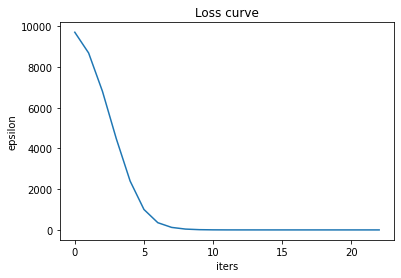

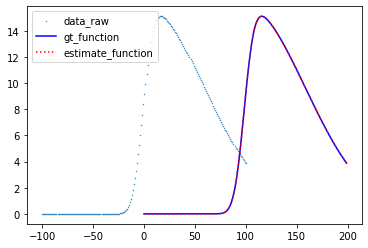

In [3]:
import matplotlib.pyplot as plt

plt.plot(eps_list)
plt.title('Loss curve')
plt.ylabel('epsilon')
plt.xlabel('iters') 
plt.show()

dot = plt.scatter(t.cpu(), data_raw.cpu(), s=0.2)
l1, = plt.plot(data.detach().cpu(), color='blue')
l2, = plt.plot(emg_model(coeffs[-1], t).detach().cpu(), 'r:')
plt.legend(handles=[dot, l1, l2], labels=['data_raw','gt_function', 'estimate_function'], loc='upper left')
plt.show()